In [11]:
import sys
import os

# Ê∑ªÂä† factor_evaluation.pyd ÊâÄÂú®ÁöÑÁõÆÂΩïÂà∞Á≥ªÁªüË∑ØÂæÑ
pyd_path = r"D:\MG\ÔºÅinternship\ÔºÅ4L CAPITAL\Âõ†Â≠êËØÑ‰º∞Âô®"
sys.path.append(pyd_path)

# ÂØºÂÖ•Ê®°Âùó
from factor_evaluation import FactorEvaluation
from factor_evaluation import DataService
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [12]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [13]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [ ]:
def compute_rsrs_base(df, window_N=16):
    """
    ËÆ°ÁÆóÂü∫Á°ÄRSRSÊåáÊ†áÔºàÊñúÁéáÂíåÂÜ≥ÂÆöÁ≥ªÊï∞Ôºâ
    """
    high = df['high'].values
    low = df['low'].values
    beta = np.full(len(df), np.nan)
    r_squared = np.full(len(df), np.nan)
    
    # ‰ΩøÁî®ÂêëÈáèÂåñÊìç‰ΩúÊèêÈ´òÊïàÁéá
    for i in range(window_N-1, len(df)):
        start_idx = i - window_N + 1
        end_idx = i + 1
        
        # ÊèêÂèñÁ™óÂè£Êï∞ÊçÆ
        X = low[start_idx:end_idx]
        y = high[start_idx:end_idx]
        
        # Ê∑ªÂä†Â∏∏Êï∞È°π
        X = np.column_stack((np.ones(window_N), X))
        
        # ËÆ°ÁÆóÂõûÂΩíÁ≥ªÊï∞
        XtX = X.T @ X
        if np.linalg.det(XtX) < 1e-5:  # ÈÅøÂÖçÂ•áÂºÇÁü©Èòµ
            continue
            
        beta_val = np.linalg.inv(XtX) @ X.T @ y
        beta[i] = beta_val[1]
        
        # ËÆ°ÁÆóR-squared
        y_pred = X @ beta_val
        ss_total = np.sum((y - np.mean(y))**2)
        ss_res = np.sum((y - y_pred)**2)
        r_squared[i] = 1 - (ss_res / ss_total) if ss_total > 0 else 0
    
    return pd.Series(beta, index=df.index), pd.Series(r_squared, index=df.index)

def rsrs_basic_factor(df, N=16):
    """
    Âü∫Á°ÄRSRSÂõ†Â≠ê - ÂõûÂΩíÊñúÁéá
    """
    beta, _ = compute_rsrs_base(df, N)
    return beta.fillna(0)

def rsrs_zscore_factor(df, N=16, M=300):
    """
    Ê†áÂáÜÂàÜRSRSÂõ†Â≠ê
    """
    beta, _ = compute_rsrs_base(df, N)
    rolling_mean = beta.rolling(M).mean()
    rolling_std = beta.rolling(M).std().replace(0, 1e-5)  # ÈÅøÂÖçÈô§‰ª•Èõ∂
    zscore = (beta - rolling_mean) / rolling_std
    return zscore.fillna(0)

def rsrs_zscore_r2_factor(df, N=16, M=300):
    """
    ‰øÆÊ≠£Ê†áÂáÜÂàÜRSRSÂõ†Â≠ê
    """
    beta, r2 = compute_rsrs_base(df, N)
    rolling_mean = beta.rolling(M).mean()
    rolling_std = beta.rolling(M).std().replace(0, 1e-5)
    zscore = (beta - rolling_mean) / rolling_std
    return (zscore * r2).fillna(0)

def rsrs_zscore_positive_factor(df, N=16, M=300):
    """
    Âè≥ÂÅèÊ†áÂáÜÂàÜRSRSÂõ†Â≠ê
    """
    beta, r2 = compute_rsrs_base(df, N)
    rolling_mean = beta.rolling(M).mean()
    rolling_std = beta.rolling(M).std().replace(0, 1e-5)
    zscore = (beta - rolling_mean) / rolling_std
    return (zscore * r2 * beta).fillna(0)

def rsrs_volume_weighted_factor(df, N=16):
    """
    Êàê‰∫§ÈáèÂä†ÊùÉRSRSÂõ†Â≠ê
    """
    high = df['high'].values
    low = df['low'].values
    volume = df['volume'].values
    beta = np.full(len(df), np.nan)
    
    for i in range(N-1, len(df)):
        start_idx = i - N + 1
        end_idx = i + 1
        
        # ÊèêÂèñÁ™óÂè£Êï∞ÊçÆ
        X = low[start_idx:end_idx]
        y = high[start_idx:end_idx]
        weights = volume[start_idx:end_idx]
        
        # Ê∑ªÂä†Â∏∏Êï∞È°π
        X = np.column_stack((np.ones(N), X))
        
        # Âä†ÊùÉÊúÄÂ∞è‰∫å‰πò
        W = np.diag(weights)
        XtWX = X.T @ W @ X
        
        if np.linalg.det(XtWX) < 1e-5:
            continue
            
        beta_val = np.linalg.inv(XtWX) @ X.T @ W @ y
        beta[i] = beta_val[1]
    
    return pd.Series(beta, index=df.index).fillna(0)

def rsrs_combined_factor(df, N=16, M=300):
    """
    ÁªÑÂêàRSRSÂõ†Â≠ê - ÁªìÂêàÂõõÁßçRSRSÂèò‰Ωì
    """
    # ËÆ°ÁÆóÂêÑÂõ†Â≠ê
    basic = rsrs_basic_factor(df, N)
    zscore = rsrs_zscore_factor(df, N, M)
    zscore_r2 = rsrs_zscore_r2_factor(df, N, M)
    zscore_positive = rsrs_zscore_positive_factor(df, N, M)
    
    # Ê†áÂáÜÂåñÂõ†Â≠ê
    factors = pd.DataFrame({
        'basic': basic,
        'zscore': zscore,
        'zscore_r2': zscore_r2,
        'zscore_positive': zscore_positive
    })
    
    # ÂΩí‰∏ÄÂåñÂ§ÑÁêÜ
    normalized = factors.apply(lambda x: (x - x.mean()) / x.std() if x.std() > 0 else x - x.mean())
    
    # ÁÆÄÂçïÂä†ÊùÉÂπ≥Âùá
    weights = np.array([0.2, 0.3, 0.3, 0.2])
    combined = normalized.dot(weights)
    
    # ÊúÄÁªàÂΩí‰∏ÄÂåñ
    abs_mean = combined.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    return combined / abs_mean

def rsrs_with_volume_factor(df, N=16, M=300):
    """
    RSRS‰∏éÊàê‰∫§ÈáèÂéãÂäõÁªÑÂêàÂõ†Â≠ê
    """
    # RSRSÂõ†Â≠ê
    rsrs_factor = rsrs_zscore_r2_factor(df, N, M)
    
    # Êàê‰∫§ÈáèÂéãÂäõÂõ†Â≠ê
    buy_pressure = df['taker_buy_turnover'] / df['turnover'].replace(0, np.nan)
    buy_pressure = buy_pressure.fillna(0.5)  # ‰∏≠ÊÄßÂÄº
    
    # Ê†áÂáÜÂåñ
    rsrs_norm = (rsrs_factor - rsrs_factor.mean()) / rsrs_factor.std()
    pressure_norm = (buy_pressure - buy_pressure.mean()) / buy_pressure.std()
    
    # ÁªÑÂêà
    combined = rsrs_norm * 0.7 + pressure_norm * 0.3
    
    # ÂΩí‰∏ÄÂåñ
    abs_mean = combined.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    return combined / abs_mean

def optimize_weights(df, factors, target):
    """
    ‰ºòÂåñÂõ†Â≠êÊùÉÈáç
    """
    X = pd.DataFrame({name: factor(df) for name, factor in factors.items()})
    y = target(df)
    
    # ÁßªÈô§Êó†ÊïàÊï∞ÊçÆ
    valid_rows = X.notna().all(axis=1) & y.notna()
    X = X.loc[valid_rows]
    y = y.loc[valid_rows]
    
    if len(X) == 0:
        return np.ones(len(factors)) / len(factors)  # ÈªòËÆ§Á≠âÊùÉÈáç
    
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_

def improved_factor(df):
    """
    ÊîπËøõÁöÑÁªÑÂêàÂõ†Â≠ê - ÂåÖÂê´Â§öÁßçRSRSÂèò‰ΩìÂíåÊàê‰∫§Èáè‰ø°ÊÅØ
    """
    # ËÆ°ÁÆóRSRSÂõ†Â≠ê
    rsrs_basic = rsrs_basic_factor(df)
    rsrs_z = rsrs_zscore_factor(df)
    rsrs_zr2 = rsrs_zscore_r2_factor(df)
    rsrs_zpos = rsrs_zscore_positive_factor(df)
    rsrs_vol = rsrs_volume_weighted_factor(df)
    
    # Êàê‰∫§ÈáèÂéãÂäõÂõ†Â≠ê
    buy_pressure = df['taker_buy_turnover'] / df['turnover'].replace(0, np.nan)
    buy_pressure = buy_pressure.fillna(0.5)
    
    # Ê†áÂáÜÂåñÊâÄÊúâÂõ†Â≠ê
    factors_to_standardize = {
        'rsrs_basic': rsrs_basic,
        'rsrs_z': rsrs_z,
        'rsrs_zr2': rsrs_zr2,
        'rsrs_zpos': rsrs_zpos,
        'rsrs_vol': rsrs_vol,
        'buy_pressure': buy_pressure
    }
    
    standardized_factors = {}
    for name, factor_series in factors_to_standardize.items():
        mean_val = factor_series.mean()
        std_val = factor_series.std()
        if std_val < 1e-5:
            standardized_factor = factor_series - mean_val
        else:
            standardized_factor = (factor_series - mean_val) / std_val
        standardized_factors[name] = standardized_factor.fillna(0)
    
    # ÂÆö‰πâÂõ†Â≠êÂ≠óÂÖ∏ÂíåÁõÆÊ†áÂáΩÊï∞
    factors_dict = {
        'rsrs_basic': lambda df: standardized_factors['rsrs_basic'],
        'rsrs_z': lambda df: standardized_factors['rsrs_z'],
        'rsrs_zr2': lambda df: standardized_factors['rsrs_zr2'],
        'rsrs_zpos': lambda df: standardized_factors['rsrs_zpos'],
        'rsrs_vol': lambda df: standardized_factors['rsrs_vol'],
        'buy_pressure': lambda df: standardized_factors['buy_pressure']
    }
    
    # ÁõÆÊ†áÂáΩÊï∞ÔºöÊú™Êù•10ÊúüÊî∂ÁõäÁéá
    target_func = lambda df: df['close'].pct_change(10).shift(-10)
    
    # ‰ºòÂåñÊùÉÈáç
    try:
        weights = optimize_weights(df, factors_dict, target_func)
    except Exception as e:
        print(f"ÊùÉÈáç‰ºòÂåñÂ§±Ë¥•: {e}")
        weights = np.ones(len(factors_dict)) / len(factors_dict)  # ÈªòËÆ§Á≠âÊùÉÈáç
    
    # ÁªÑÂêàÂõ†Â≠ê
    combined_factor = sum(weight * factor(df) for weight, factor in zip(weights, factors_dict.values()))
    
    # ÊúÄÁªàÂΩí‰∏ÄÂåñÂ§ÑÁêÜ
    abs_mean = combined_factor.abs().rolling(50, min_periods=1).mean().clip(1e-5, None)
    normalized_factor = combined_factor / abs_mean
    
    return normalized_factor

In [15]:
evaluator.set_factor(
    factor_data_or_func=improved_factor,
    factor_name='improved_rsrs_factor'
)


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): 0.012753
   Rank_IC (Spearman): 0.019826
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: -0.044218
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 130650
   Âõ†Â≠êÂàó: improved_rsrs_factor
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 10
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------
üìä ÊòæÁ§∫ÂàÜÁªÑÂàÜÊûêÂõæ...


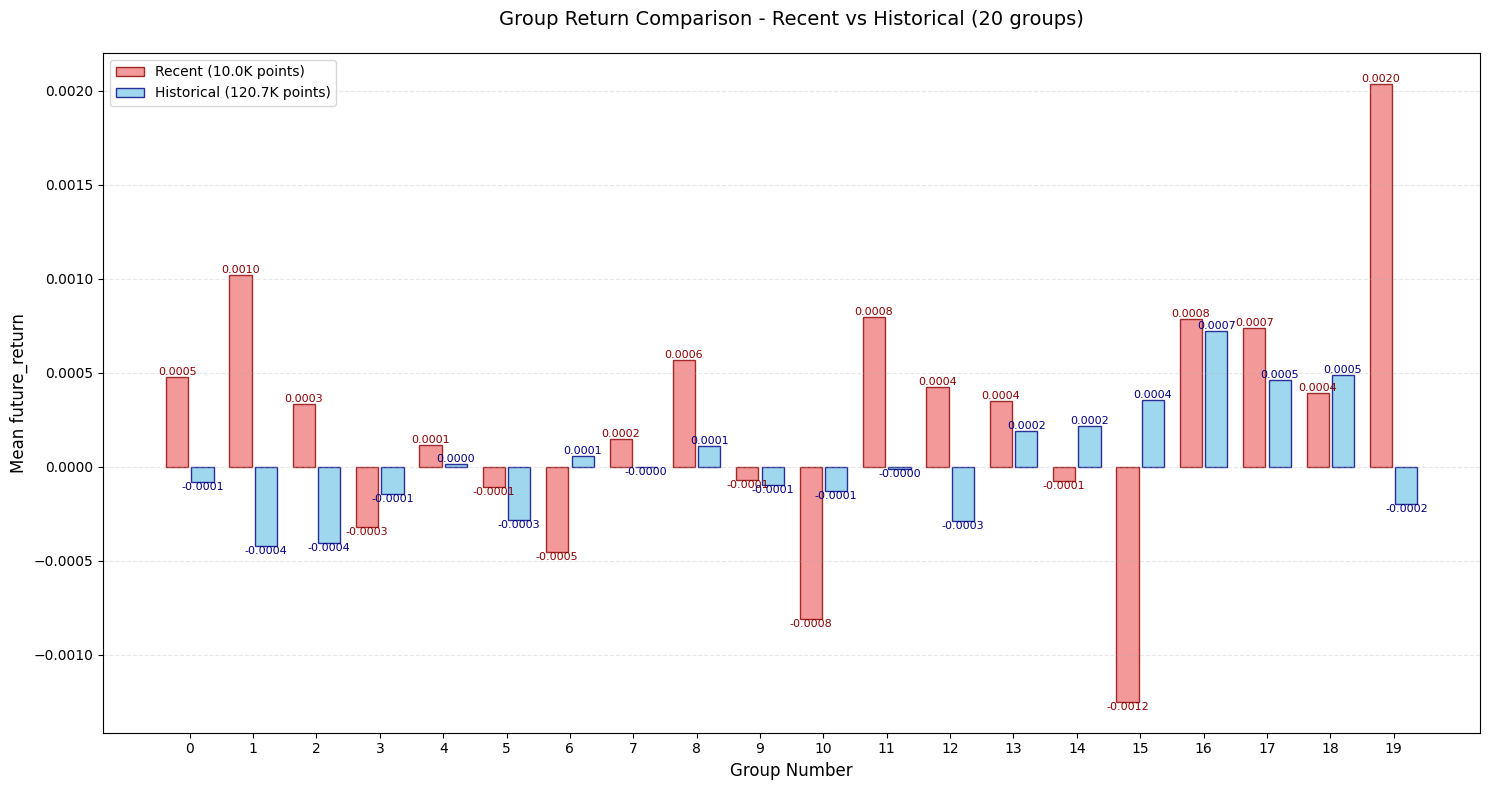

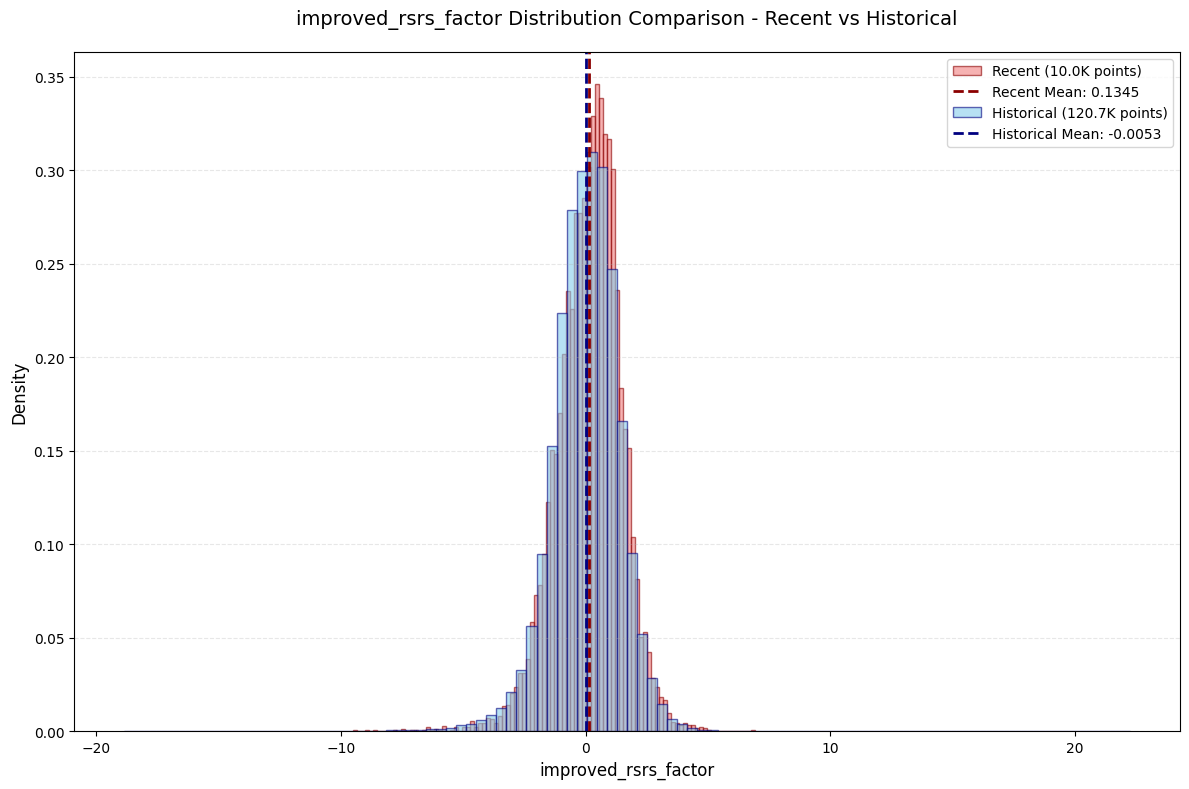

üìà ÊòæÁ§∫Âõ†Â≠êÂàÜÂ∏ÉÂõæ...
‚úÖ Â∑≤ÊòæÁ§∫ 2 ‰∏™ÂõæÁâá
----------------------------------------


In [16]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)